# Final Project Title
## Yash Joon, Brendan Collins, Thien-An Nguyen, Rennie Pearson

<img src="Clash.jpeg" alt="Alternative text" width ="500" height = "500"/>

## Introduction
Clash royale is a tower defense strategy game in which players create a deck of 8 cards and battle each other to destroy opponent's tower. The cards are characters within the game that can either defend against enemy cards or attack the enemy. Cards cost elixir to be played which is generated continuously throughout the game. The cards fall into three different type categories, units, spells, and buildings which includes spawners, defense and siege cards. The type of the card describes its behavior within the game. The cards are also split into different rarities: common, rare, epic, legendary, and champion. Many players believe that higher rarity cards will aid players in winning more games, making the game “pay to win”. 

In this analysis, we aim to find the most optimal deck(s) based on various factors. These factors include rarity, occurrence, type, cost, and winrate of a card and of a deck. We also will determine if higher rarity cards actually do lead to higher win rate, making the game “pay to win.” 


## Data Collection/Curation
### Obtaining the Dataset
This dataset is a publicly available dataset obtained from [Kaggle](https://www.kaggle.com/datasets/nonrice/clash-royale-battles-upper-ladder-december-2021?resource=download). It consists of two csv files, data_ord.csv and cardlist.csv. The data_ord.csv file contains information from about 750000 matches including the decks both players used, their respective ranks within the game, and who won. The cardlist.csv file contains a list of all the cards present in the game for the version of the game tied to this data. The card list only included the name of the card along with an id.

### Adding Relevant Information to the Dataset
- In the data_ord.csv, we updated the outcome of the match to correspond with the player number, either 1 or 2. 
- Significant changes were made to the cardlist.csv file. We added columns indicating elixir cost, rarity, type, whether a unit is flying, the targets of a card, and whether a card spawns other units.

## Data management/representation
We loaded both datasets into [Pandas](https://pandas.pydata.org/) dataframes to ensure easy data access. We had data_card_list load in cardlist.csv and data_games load in data_ord.csv. Plots were done using [Matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/).

In [158]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from collections import Counter
import math
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [159]:
data_games = pd.read_csv("data_ord.csv")
data_card_list = pd.read_csv("cardlist.csv")

### Finding Each Card

Within the cardlist.csv, there are 112 unique cards present in the data.

For each card, we want to find the number of occurrences. To do this, we analyzed the data_games dataframe and determined the number of wins and occurrences of each card, cross checking the ID from data_games with data_card_list. It was found that there are 106 used cards of the 112 cards in cardlist.csv. From that information, we were able to determine the win rate of each card and then got the corresponding name, cost, type, and rarity from the data_card_list dataframe.

In [160]:
# Card Section
# Extracting interesting card data
cards_winning = {} # All cards that won and how many times they were found
cards_winning = defaultdict(lambda:0, cards_winning)
cards_general = {} # All cards and how many times they were found
cards_general = defaultdict(lambda: 0, cards_general)
most_common = 0 
maximum = 0 

# This function keeps track of the total number of times the card was used as well as the number 
# of times it won.
def get_card_occurence(cards_used, outcome): 
    global card_general
    global cards_winning
    i = 0 
    for card in cards_used:
        cards_general[card] = cards_general[card] + 1
        if outcome == 1 and i < 8:
            cards_winning[card] = cards_winning[card] + 1
        elif outcome == 2 and i >= 8: 
            cards_winning[card] = cards_winning[card] + 1
        i = i+1
    
lst = []
# Apply function to all card IDs in each game
data_games.apply(lambda x: get_card_occurence([x["p1card1"],x["p1card2"],x["p1card3"],x["p1card4"],x["p1card5"],x["p1card6"],x["p1card7"],x["p1card8"],x["p2card1"],x["p2card2"],x["p2card3"],x["p2card4"],x["p2card5"],x["p2card6"],x["p2card7"],x["p2card8"]],x["outcome"]), axis=1)

# Gets the total occurrence of each card
data_cards = pd.DataFrame.from_dict([cards_general]).transpose().reset_index()
data_cards

,index,0
0,8,45795
1,34,66651
2,37,215819
3,52,45047
4,69,62900
...,...,...
101,79,5542
102,24,53761
103,61,37426
104,100,23811


#### Gathering Important Card Data
While going through to determine the number of occurrences, we also determined the number of wins of each card to then be able to calculate the win rate of each card. In doing so, we then realize we’d have to take into account the number of wins relative to the number of occurrences. For example, a card with a high win rate but very few games played isn’t all that meaningful to our data and any possible correlations.

To go a step further in exploring data relative to cards, we wanted to look at the specifics of a card's attributes and determine any rates based off of them. As mentioned, every card has a type (unit, spell, spawner, building, siege, defense), elixir cost (0-9), and rarity (common, rare, epic, legendary, champion). Going through the card_df dataframe, each card has these attributes labeled so to find the win rate for each classification of a particular attribute, we took the average win rate of each card containing that attribute and graphed each attribute by category comparing the win rate and occurrences. 

In [161]:
# Rename the columns of the card_df dataframe to correspond to it's name
card_df = data_cards
card_df.rename(columns={0: 'occurrences', 'index': 'card'}, inplace=True)

# Make a wins_df that gets the number of wins of each card and rename column values
wins_df = pd.DataFrame.from_dict([cards_winning]).transpose().reset_index()
wins_df.rename(columns={0: 'wins', 'index': 'card'}, inplace=True)

# Sort each dataframe and merge the number of wins and total number of occurrences
card_df.sort_values(by=['occurrences'], inplace=True, ascending=False)
wins_df = wins_df.merge(right=card_df)
wins_df.sort_values(by=['wins'], inplace=True, ascending=False)


# Calculate the win rate of each card and add it into the dataframe in a new column
for index, row in wins_df.iterrows():    
    wins_df.at[index, 'winrate'] = row['wins'] / row['occurrences']

# Sort values by winrate and set card_df to the merged dataset
wins_df.sort_values(by=['winrate'], inplace=True, ascending=False)

card_df = wins_df

# Gather the card name, cost, rarity, and type nad put it into the dataframe card_df
for index, row in card_df.iterrows():
    tup = (data_card_list.at[row['card'], 'card'], data_card_list.at[row['card'], 'cost'], data_card_list.at[row['card'], 'rarity'], data_card_list.at[row['card'], 'type'])
    card_df.at[index, 'card_name'] = tup[0]
    card_df.at[index, 'cost'] = tup[1]
    card_df.at[index, 'rarity'] = tup[2]
    card_df.at[index, 'type'] = tup[3]

card_df

,card,wins,occurrences,winrate,card_name,cost,rarity,type
54,54,32352,61037,0.530039,Cannon Cart,5.0,epic,unit
98,70,22406,42334,0.529267,Skeleton Dragons,4.0,common,unit
1,34,35229,66651,0.528559,Bowler,5.0,epic,unit
21,102,131432,249380,0.527035,Barbarian Barrel,2.0,epic,spell
84,29,39698,75386,0.526596,Lava Hound,7.0,legendary,unit
...,...,...,...,...,...,...,...,...
86,20,13481,28556,0.472090,Giant Skeleton,6.0,epic,unit
63,64,55273,117924,0.468717,Firecracker,3.0,common,unit
85,7,39768,86820,0.458051,Witch,5.0,epic,unit
66,17,45181,104706,0.431503,Wizard,5.0,rare,unit


### Finding Each Deck
We find each unique deck that was used. There are a projected 278,818,865,325 possible decks, but for 750,000 games, there are roughly 1,500,000 possible unique decks. The data_games dataframe was analyzed to determine each deck used in a game, count the occurrences of the deck, and find the average trophy amount for each deck.

In [162]:
# Deck Section
# Extracting interesting deck data
dict_decks_general = {} # All decks and how many times they were found
dict_decks_general = defaultdict(lambda:0,dict_decks_general) # zero filled dictionary
dict_decks_winning_only = {} # All decks that won a game, and how many times they won
dict_decks_winning_only = defaultdict(lambda:0,dict_decks_winning_only) # zero filled dictionary

dict_decks_trophies = {}
dict_decks_trophies = defaultdict(lambda:0,dict_decks_trophies) # zero filled dictionary


# function to obtain deck info
# Takes in the player 1 and player 2 decks and the outcome of the match
def get_decks(p1_deck,p2_deck,p1_trophies,p2_trophies,result):
    global dict_decks_general
    global dict_decks_winning_only
    global dict_decks_trophies
    dict_decks_general[p1_deck] = dict_decks_general[p1_deck] + 1 # add 1 to player 1's deck occurrences
    dict_decks_general[p2_deck] = dict_decks_general[p2_deck] + 1 # add 1 to player 2's deck occurrences
    dict_decks_trophies[p1_deck] = dict_decks_trophies[p1_deck] + p1_trophies
    dict_decks_trophies[p2_deck] = dict_decks_trophies[p2_deck] + p2_trophies
    if(result == 1):
        dict_decks_winning_only[p1_deck] = dict_decks_winning_only[p1_deck] + 1 # if player 1 wins add 1 to player 1's deck occurrences for winning decks
    else:
        dict_decks_winning_only[p2_deck] = dict_decks_winning_only[p2_deck] + 1 # if player 2 wins add 1 to player 2's deck occurrences for winning decks

# apply function to data_frame containing games
data_games.apply(lambda x: get_decks((x["p1card1"],x["p1card2"],x["p1card3"],x["p1card4"],x["p1card5"],x["p1card6"],x["p1card7"],x["p1card8"]),(x["p2card1"],x["p2card2"],x["p2card3"],x["p2card4"],x["p2card5"],x["p2card6"],x["p2card7"],x["p2card8"]),x["p1trophies"],x["p2trophies"],x["outcome"]), axis=1)

# create new dataframe containing information found
# has the columns 'Deck', 'Occurrences', and 'Wins'
data_decks = pd.DataFrame.from_dict([dict_decks_general]).transpose().reset_index().rename(columns={"index": "Deck", 0: "Occurrences"})
data_decks['Wins'] = data_decks['Deck'].apply(lambda x: dict_decks_winning_only[x])
data_decks['Trophies'] = dict_decks_trophies.values()
data_decks['Trophies'] = data_decks['Trophies']/data_decks['Occurrences']
data_decks

,Deck,Occurrences,Wins,Trophies
0,"(8, 34, 37, 52, 69, 88, 92, 97)",30,17,6963.566667
1,"(11, 12, 13, 58, 77, 86, 87, 98)",22,9,7339.909091
2,"(11, 37, 53, 83, 88, 92, 97, 102)",183,83,6996.245902
3,"(19, 22, 25, 32, 54, 76, 87, 98)",1778,959,6912.115861
4,"(28, 38, 43, 46, 50, 81, 102, 103)",1910,1064,6769.385864
...,...,...,...,...
327653,"(7, 15, 17, 21, 43, 81, 87, 89)",1,1,5577.000000
327654,"(13, 35, 39, 43, 48, 73, 95, 99)",1,1,6087.000000
327655,"(11, 17, 18, 24, 51, 77, 95, 102)",1,1,5838.000000
327656,"(4, 7, 11, 21, 64, 77, 88, 92)",1,0,5858.000000


Looking at the number of decks found reveals to us that people tend to use similar decks. There were roughly 300,000 unique decks used throughout the 750,000 matches. One reason for this is that certain decks might just be more competitively viable than others. Players are more likely to use a deck that will allow them to win.

### Gathering Important Data About Decks
Here we will obtain important statistics about each deck used. This includes things like the deck composition, rarity, average elixir cost, and Win Rate. Composition is stored as a string of 3 numbers. The character at index 0 corresponds to the number of buildings in the deck, at index 1 the number of spells, and at index 2 the number of units. Rarity is stored as a string of 5 numbers. The character at index 0 corresponds to the number of champions in the deck (which can at most be 1), at index 1 the number of legendaries, and at index 2 the number of epics, at index 3 the number of rares, and at index 4 the number of commons.

In [163]:
# Obtain deck specific info
comps = [] # 1 to 1 list of compostion of each deck
rarities = [] # 1 to 1 list of rarities in each deck
costs = [] # 1 to 1 list of cost of each deck

# function to find the important information for each deck
def findComp(deck):
    global comps
    global rarities
    comp = 0
    rarity = 0
    total = 0
    # for each card in the deck
    for card in deck:
        curr_type = data_card_list.loc[card].type # find type of card
        curr_rarity = data_card_list.loc[card].rarity # find rarity of card
        total += data_card_list.loc[card].cost # find cost of card
        # adjust the compostion accordingly
        if(curr_type == "unit"):
            comp += 1
        elif(curr_type == "spell"):
            comp += 10
        elif(curr_type == "defense" or curr_type == "spawner" or curr_type == "siege" or curr_type == "building"):
            # defense, spawner, siege, and buildings all count as buildings
            comp += 100
            
        # adjust the rarity accordingly
        if(curr_rarity == "common"):
            rarity += 1
        elif(curr_rarity == "rare"):
            rarity += 10
        elif(curr_rarity == "epic"):
            rarity += 100
        elif(curr_rarity == "legendary"):
            rarity += 1000
        elif(curr_rarity == "champion"):
            rarity += 10000
    # pad the composition string and rarity string with zeros to allow for accuracte indexing
    comps.append(str(comp).zfill(3))
    rarities.append(str(rarity).zfill(5))
    # find average elixir cost of deck
    costs.append(total/8)
    
# call function to find information on each deck
data_decks['Deck'].apply(lambda x: findComp(x))
# Create 'Rarity', 'Composition',and 'Costs' columns based on results
data_decks['Rarity'] = rarities
data_decks['Composition'] = comps
data_decks['Costs'] = costs
# Find the win rate of each deck and save it in 'Win Rate' columns
data_decks['Win Rate'] = data_decks.apply(lambda x: x['Wins']/x['Occurrences'], axis=1)
data_decks.head()

,Deck,Occurrences,Wins,Trophies,Rarity,Composition,Costs,Win Rate
0,"(8, 34, 37, 52, 69, 88, 92, 97)",30,17,6963.566667,12212,035,4.25,0.566667
1,"(11, 12, 13, 58, 77, 86, 87, 98)",22,9,7339.909091,01331,224,3.25,0.409091
2,"(11, 37, 53, 83, 88, 92, 97, 102)",183,83,6996.245902,02213,143,3.75,0.453552
3,"(19, 22, 25, 32, 54, 76, 87, 98)",1778,959,6912.115861,02213,125,3.50,0.539370
4,"(28, 38, 43, 46, 50, 81, 102, 103)",1910,1064,6769.385864,02141,116,4.00,0.557068


## Data Analysis

### Card Analysis
#### Finding the Most Popular Cards


In [164]:
# Get the top 5 occurring card sorted in descending order
display(card_df.sort_values(by=['occurrences'], ascending=False).head(5))

,card,wins,occurrences,winrate,card_name,cost,rarity,type
31,87,226342,452233,0.500499,Fireball,4.0,rare,spell
13,98,219010,441936,0.495569,The Log,2.0,legendary,spell
32,95,193913,389347,0.498047,Zap,2.0,common,spell
16,11,150391,314353,0.478414,Valkyrie,4.0,rare,unit
30,42,152439,299980,0.508164,Electro Wizard,4.0,legendary,unit


Sorting by occurrence, we can find the top 5 popular cards. The fireball is the most popular with 45,000 occurrences which may be because it is accessible to players almost immediately when they start. 


#### Finding the Least Popular Cards


In [165]:
# Get the 5 least popular cards by sorting in ascending order and getting the first 5 cards
display(card_df.sort_values(by=['occurrences'], ascending=True).head(5))

,card,wins,occurrences,winrate,card_name,cost,rarity,type
104,79,2746,5542,0.495489,Barbarian Hut,6.0,rare,spawner
67,28,6494,12503,0.519395,Three Musketeers,9.0,rare,unit
105,67,6420,13071,0.491164,Skeleton King,4.0,champion,unit
87,2,7270,14658,0.495975,Goblins,2.0,common,unit
62,81,7731,15325,0.504470,Elixir Collector,6.0,rare,building



We see that the least used card is Barbarian Hut with only 5542 occurrences in total. The other four cards have similar values ranging from 12500 to 15300. 

#### Finding the Highest Win Rate Cards

In [166]:
# Get the first 5 highest win rate cards by sorting win rate in descending order
display(card_df.sort_values(by=['winrate'], ascending=False).head(5))

,card,wins,occurrences,winrate,card_name,cost,rarity,type
54,54,32352,61037,0.530039,Cannon Cart,5.0,epic,unit
98,70,22406,42334,0.529267,Skeleton Dragons,4.0,common,unit
1,34,35229,66651,0.528559,Bowler,5.0,epic,unit
21,102,131432,249380,0.527035,Barbarian Barrel,2.0,epic,spell
84,29,39698,75386,0.526596,Lava Hound,7.0,legendary,unit


This section finds the top 5 highest win rate cards by sorting by winrate. We found that Cannon Cart is the highest winrate card with a win rate of 0.53.

#### Finding the Lowest Win Rate Cards

In [167]:
# Get the 5 lowest win rate cards by sorting win rate in ascending order
display(card_df.sort_values(by=['winrate'], ascending=True).head(5))

,card,wins,occurrences,winrate,card_name,cost,rarity,type
61,93,14196,33035,0.429726,Mirror,0.0,epic,spell
66,17,45181,104706,0.431503,Wizard,5.0,rare,unit
85,7,39768,86820,0.458051,Witch,5.0,epic,unit
63,64,55273,117924,0.468717,Firecracker,3.0,common,unit
86,20,13481,28556,0.472090,Giant Skeleton,6.0,epic,unit


This is similar to the highest win rate but sort by ascending values instead of descending. It’s found that Mirror has the lowest win rate of 0.429 and having a lower occurrence of 33,035.

#### Analyzing win rate based on elixir cost
In this code block, we will look at the relationship between Win Rate and the Cost of each card using a scatter plot

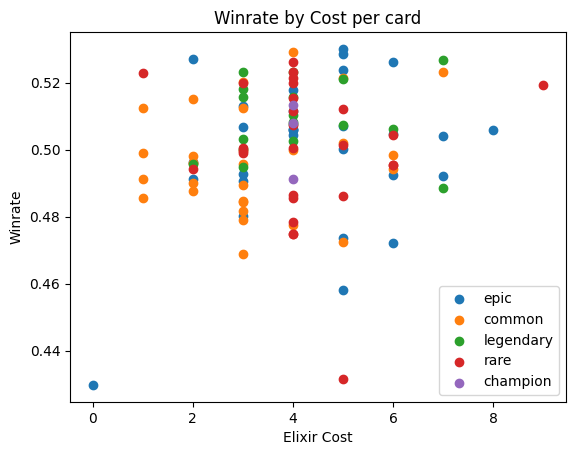

In [168]:
# make a scatter plot of winrate by elixir cost per card

# Loop through the different rarities and then plot points onto a scatter plot
# based on each rarity
for rarity in card_df['rarity'].unique():
    rarity_lst = card_df[card_df['rarity'] == rarity]

    plt.scatter(rarity_lst['cost'], rarity_lst['winrate'], label=rarity)

# Define labels and titles
plt.title('Winrate by Cost per card')
plt.xlabel('Elixir Cost')
plt.ylabel('Winrate')
plt.legend(loc='lower right')
plt.show()

From this scatter plot, we can see that the majority of cards have a win rate of greater than or equal to 50%. However, it is also shown that the upside of .5 has a smaller range than the downside. This means that a win rate greater than 50% is likely to only be better by a smaller range whereas a win rate less than 50% is going to be worse by a large range.
#### Analyzing win rate based on rarity
For this block, we will look at how win rate is affected by the rarity of the card. We want to know the mean as well as the ranges these values are in.

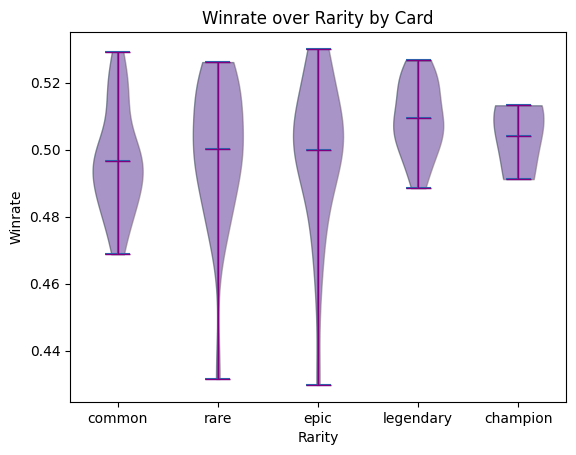

In [169]:
# Go through each rarity in the dataset and add the winrate to an empty list lst
# based on the rarity
lst = []
rarities = ['common', 'rare', 'epic', 'legendary', 'champion']
for rarity in rarities:
    lst.append(card_df[card_df['rarity'] == rarity].winrate)
    
# Create a violinplot based on the list lst 
fig, ax = plt.subplots()
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(rarities)
ax.violinplot(lst, showmeans=True)

# Change colors of the graph
violin_plot = ax.violinplot(lst, showmeans=True)
for vs in violin_plot['bodies']:
    vs.set_facecolor('purple')
    vs.set_edgecolor('black')
for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = violin_plot[partname]
    vp.set_edgecolor('purple')
    vp.set_linewidth(1)

# Define title and labels of the graph
ax.set_xlabel('Rarity')
ax.set_ylabel('Winrate')
ax.set_title('Winrate over Rarity by Card')
plt.show()

From the violinplot, we see that the average win rate of legendary units has a higher value compared to all of the other rarity types. The other rarities’ mean win rate congregate around ~0.50 while legendary mean win rate is higher at approximately 0.51. Another thing to note is that legendary and champion units both have a smaller range compared to common, rare, and epic units. 
#### Find occurrences of cards by rarity
In this code block, we will look at the occurrence of each card rarity. 

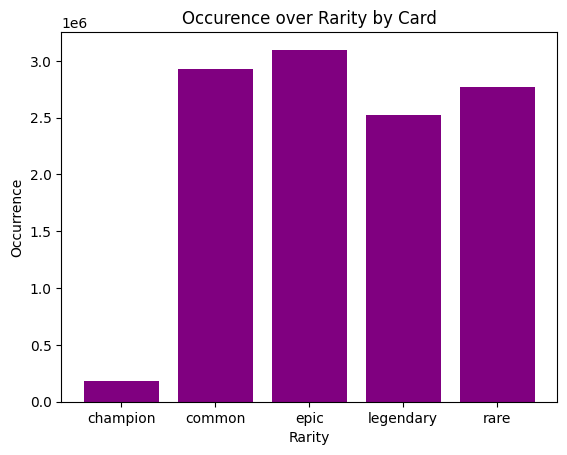

In [170]:
# Loop through each rarity in the dataset and add the occurrences to an empty list lst
lst = []
rarities = ['common', 'rare', 'epic', 'legendary', 'champion']
for rarity in rarities:
    lst.append(card_df[card_df['rarity'] == rarity].occurrences)
    
# Plot the total occurrences by rarity
fig, ax = plt.subplots()
ax.bar(card_df.groupby('rarity')['occurrences'].sum().index,card_df.groupby('rarity')['occurrences'].sum().values,color = "purple")
ax.set_xlabel('Rarity')
ax.set_ylabel('Occurrence')
ax.set_title('Occurence over Rarity by Card')
plt.show()

We see from the graph that champion units are the least used of all the rarities. The other rarities are similar in occurrence, with legendary units being the smallest of the group. From the violin plot displaying win rate over rarity, we see that legendary and champion cards have the smallest spread of win rate. However, it seems that champion cards have a smaller spread because less people use those types of cards. Meanwhile, legendary cards have a slightly larger spread but they have a high occurrence while having higher average win rate. This could mean that legendary cards are more useful and perform better than the other rarity types.


#### Analyzing win rate based on occurrences

This code block creates a scatter plot to visualise the relationship between win rate and occurrences.

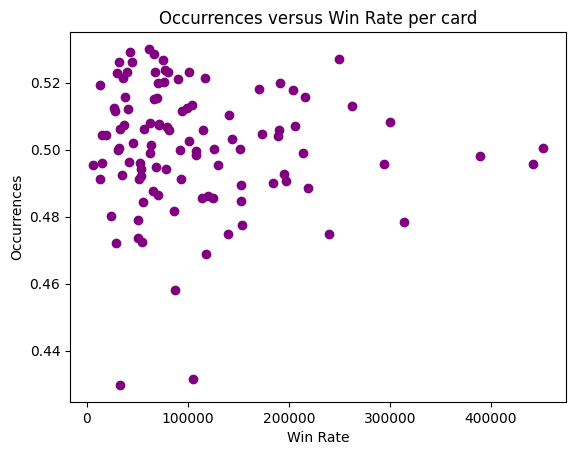

In [171]:
fig, ax = plt.subplots()
# Setting labels
ax.set_ylabel("Occurrences")
ax.set_xlabel("Win Rate")
ax.set_title("Occurrences versus Win Rate per card")
# Plotting occurences by winrate
ax.scatter(card_df["occurrences"],card_df["winrate"],color = "purple")
plt.show()

You notice from the scatter plot that most cards have around 50% or higher winrate with the exception of a few outliers.

You also notice that most cards are used about the same amount, in around 100,000 games. 

However, cards with relatively higher win rates have relatively lower occurrences than some cards with the same rate. 

The more a card is used the more likely the win rate is to fall but that makes the win rate more reliable. 

You notice a few outliers with exceptionally more occurrences but a relatively equal win rate. 

#### Analyzing win rate based on type of card

In this code block, we will visualise at the relationship between Win Rate and the Types of cards using a scatter plot

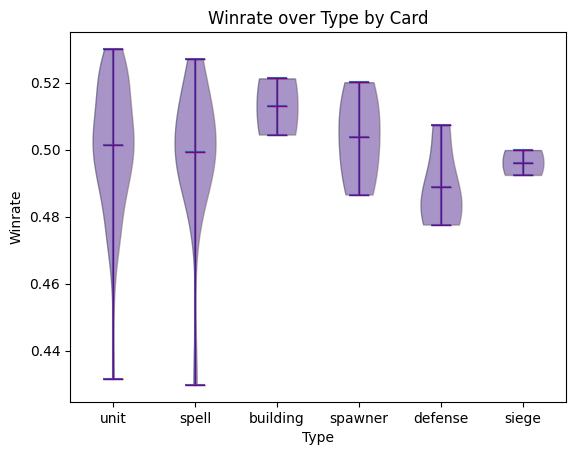

In [172]:
# Loop through the unit types and add the winrate based on the type to an empty list lst
lst = []
types = ['unit', 'spell', 'building', 'spawner', 'defense', 'siege']
for _type in types:
    lst.append(card_df[card_df['type'] == _type].winrate)

# Create a violinplot based off of the values in lst
fig, ax = plt.subplots()
ax.set_xticks([1, 2, 3, 4, 5, 6])
ax.set_xticklabels(types)
ax.violinplot(lst, showmeans=True)

# Change the colors of the violin plot
violin_plot = ax.violinplot(lst, showmeans=True)
for vs in violin_plot['bodies']:
    vs.set_facecolor('purple')
    vs.set_edgecolor('black')
for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = violin_plot[partname]
    vp.set_edgecolor('purple')
    vp.set_linewidth(1)
    
# Define labels and title
ax.set_xlabel('Type')
ax.set_ylabel('Winrate')
ax.set_title('Winrate over Type by Card')
plt.show()

The violin plot shows that building type cards have the highest average win rate followed by spawner and unit cards. 

You notice that the types with less cards in their category have a much less skewed distribution while the types with more cards have more noticeable range and skew. 

The plot would suggest that buildings are a safe pick with particular unit, spawner and spell cards to have an efficient deck. 

### Deck Analysis
In this section, we analyze the usage statistics of decks. We find which decks are the most popular, which have the most wins, and what common deck composition looks like.

#### Finding the most popular decks
The first part of the analysis of decks is finding out which decks were used the most. These are the 5 most common decks.

In [173]:
# Finding the 5 most common decks
display(data_decks.sort_values(by=['Occurrences'], ascending=False).head(5))

,Deck,Occurrences,Wins,Trophies,Rarity,Composition,Costs,Win Rate
13,"(10, 14, 21, 30, 38, 74, 87, 98)",32405,15767,6395.736399,01043,125,2.625,0.486561
27,"(4, 36, 42, 46, 50, 62, 87, 95)",24027,12734,6576.361468,04121,026,3.875,0.529987
176,"(0, 26, 30, 41, 77, 90, 91, 98)",18166,8849,6302.657382,02123,134,3.250,0.487119
14,"(6, 34, 35, 37, 63, 92, 99, 102)",16286,9002,6612.563552,02600,035,4.000,0.552745
43,"(0, 1, 10, 72, 80, 82, 87, 98)",10385,5229,6587.376312,01115,224,3.000,0.503515


The second part of analysis is looking at which decks won the most. Interestingly, the third most common deck has less wins than the fourth most common deck, despite having almost 20,000 more games.

In [174]:
# Finding the 5 most winning decks
display(data_decks.sort_values(by=['Wins'], ascending=False).head(5))

,Deck,Occurrences,Wins,Trophies,Rarity,Composition,Costs,Win Rate
13,"(10, 14, 21, 30, 38, 74, 87, 98)",32405,15767,6395.736399,01043,125,2.625,0.486561
27,"(4, 36, 42, 46, 50, 62, 87, 95)",24027,12734,6576.361468,04121,026,3.875,0.529987
14,"(6, 34, 35, 37, 63, 92, 99, 102)",16286,9002,6612.563552,02600,035,4.000,0.552745
176,"(0, 26, 30, 41, 77, 90, 91, 98)",18166,8849,6302.657382,02123,134,3.250,0.487119
43,"(0, 1, 10, 72, 80, 82, 87, 98)",10385,5229,6587.376312,01115,224,3.000,0.503515


#### Analyzing Deck Composition
##### Finding the most common compositions
Each deck has 8 cards. The types of cards are unit, spell, and building. There can be at most 8 cards of a type in a deck. It is also possible that there are no cards of a type in a deck. We find the 5 most common compositions of decks in terms of type of cards.

In [175]:
# Finding the 5 most common general compositions
most_common_comps = data_decks['Composition'].value_counts()[0:5]

for index in most_common_comps.index:
    print("Buildings: "+index[0]+", Spells: "+index[1]+", Units: "+index[2]," | Occurences: "+str(most_common_comps[index]))
    # Finding most popular deck of each composition in the top 5
    deck = ""
    for card in data_decks[data_decks['Composition'] == index].sort_values(by=['Occurrences'], ascending=False).head(1)['Deck'].values[0]:
        deck = deck + " " + data_card_list.loc[card].card + ","
    print("Deck: "+ deck[:-1]+"\n")

Buildings: 0, Spells: 2, Units: 6  | Occurences: 91676
Deck:  P.E.K.K.A, Battle Ram, Electro Wizard, Bandit, Royal Ghost, Magic Archer, Fireball, Zap

Buildings: 1, Spells: 2, Units: 5  | Occurences: 66117
Deck:  Skeletons, Musketeer, Hog Rider, Ice Spirit, Ice Golem, Cannon, Fireball, The Log

Buildings: 0, Spells: 3, Units: 5  | Occurences: 42565
Deck:  Balloon, Bowler, Lumberjack, Inferno Dragon, Electro Dragon, Freeze, Tornado, Barbarian Barrel

Buildings: 0, Spells: 1, Units: 7  | Occurences: 38373
Deck:  Spear Goblins, Miner, Inferno Dragon, Goblin Gang, Bats, Mega Knight, Skeleton Barrel, Zap

Buildings: 1, Spells: 3, Units: 4  | Occurences: 31398
Deck:  Knight, Princess, Ice Spirit, Goblin Gang, Inferno Tower, Rocket, Goblin Barrel, The Log



The most common composition is 0 buildings, 2 spells, and 6 units. Generally, the number of buildings < number of spells < number of units. We noticed that most of these decks contain unique units but the spells are similar. This makes sense given that the most popular cards tended to be spells.

##### Finding the least common compositions
In this section we find the 5 least common deck compositions.

In [176]:
# Finding 5 least common compositions
least_common_comps = data_decks['Composition'].value_counts()[-6:]

for index in least_common_comps.index:
    print("Buildings: "+index[0]+", Spells: "+index[1]+", Units: "+index[2]," | Occurences: "+str(least_common_comps[index]))
    # Finding least popular deck of each composition in bottom top 5
    deck = ""
    for card in data_decks[data_decks['Composition'] == index].sort_values(by=['Occurrences'], ascending=False).head(1)['Deck'].values[0]:
        deck = deck + " " + data_card_list.loc[card].card + ","
    print("Deck: "+ deck[:-1]+"\n")

Buildings: 4, Spells: 0, Units: 4  | Occurences: 6
Deck:  Bowler, Dart Goblin, Flying Machine, Firecracker, Goblin Hut, Elixir Collector, Tombstone, Furnace

Buildings: 6, Spells: 1, Units: 1  | Occurences: 5
Deck:  Fire Spirit, Goblin Hut, Bomb Tower, Barbarian Hut, Tesla, Tombstone, Furnace, Mirror

Buildings: 8, Spells: 0, Units: 0  | Occurences: 5
Deck:  Cannon, Goblin Hut, Mortar, Barbarian Hut, Tesla, X-Bow, Tombstone, Furnace

Buildings: 7, Spells: 0, Units: 1  | Occurences: 4
Deck:  Cannon Cart, Inferno Tower, Bomb Tower, Barbarian Hut, Tesla, X-Bow, Furnace, Goblin Drill

Buildings: 6, Spells: 0, Units: 2  | Occurences: 1
Deck:  Skeleton Army, Mini P.E.K.K.A, Cannon, Mortar, Inferno Tower, Bomb Tower, Tesla, Tombstone

Buildings: 5, Spells: 0, Units: 3  | Occurences: 1
Deck:  Ice Spirit, Fire Spirit, Golden Knight, Goblin Hut, Barbarian Hut, Tombstone, Furnace, Goblin Drill



The least common composition is 5 buildings, 0 spells, and 3 units. Generally, the number of buildings > number of spells and number of units. This would indicate that buildings are generally not used very often, especially in high concentrations.

##### Visualizing the Compositions
In order to visualize the typical composition of decks, we created a bar chart to indicate how common a certain composition was. The x-axis corresponds to the number of the type of card in the deck while the y-axis corresponds to the number of occurrences of this format.

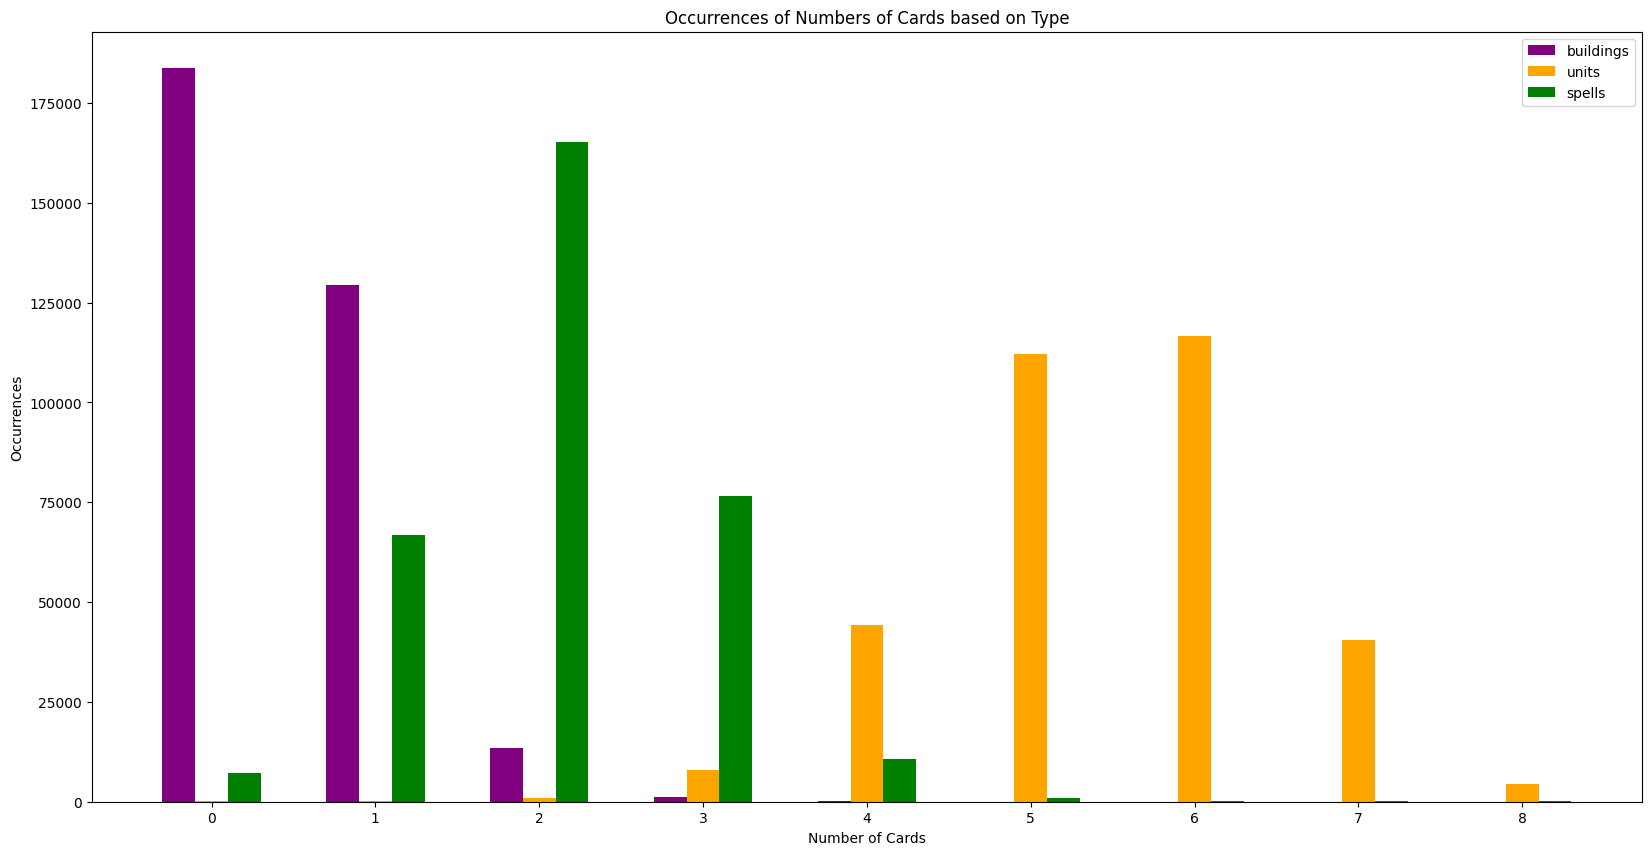

In [177]:
units = data_decks['Composition'].apply(lambda x: int(x[2])).value_counts() # counting the number of units for each deck
spells = data_decks['Composition'].apply(lambda x: int(x[1])).value_counts() # counting the number of spells for each deck
buildings = data_decks['Composition'].apply(lambda x: int(x[0])).value_counts() # counting the number of buildings for each deck

# Creating plot
fig, ax = plt.subplots(figsize=(20,10))
# Setting labels
ax.set_ylabel("Occurrences")
ax.set_xlabel("Number of Cards")
ax.set_title("Occurrences of Numbers of Cards based on Type")
# Plotting occurrences of each composition
ax.bar(buildings.index-.2, buildings.values, .2, label='buildings',color="purple")
ax.bar(units.index, units.values, .2, label='units',color ="orange")
ax.bar(spells.index + .2, spells.values, .2, label='spells',color="green")
ax.set_xticks(np.arange(9), ['0','1','2','3','4','5','6','7','8'])
plt.legend(loc="upper right")
plt.show()

It appears that the most common composition is 0 buildings, 2 spells, and 6 units. This agrees very well with the results from the previous step of finding the 5 most common compositions. The majority of decks tend to run 0 or 1 buildings. This also agrees with our findings that buildings are not typically used in high numbers. The usage data for spells and units is normally distributed, while the usage data of buildings is not. 

#### Analyzing Deck Rarity Composition
##### Finding the most common rarity composition
This section will analyze common rarity compositions for decks. There are 5 different types of rarities. In increasing rarity, these are common, rare, epic, legendary, and champion. Each deck can have at most one champion in it. 

In [178]:
# Finding the 5 most common rarities
most_common_rars = data_decks['Rarity'].value_counts()[0:5]

for index in most_common_rars.index:
    print("Champions: "+index[0]+", Legendaries: "+index[1]+", Epics: "+index[2]+", Rares: "+index[3]+", Commons: "+index[4]," | Occurences: "+str(most_common_rars[index]))
    # Finding least popular deck of each composition in bottom top 5
    deck = ""
    for card in data_decks[data_decks['Rarity'] == index].sort_values(by=['Occurrences'], ascending=False).head(1)['Deck'].values[0]:
        deck = deck + " " + data_card_list.loc[card].card + ","
    print("Deck: "+ deck[:-1]+"\n")

Champions: 0, Legendaries: 2, Epics: 2, Rares: 2, Commons: 2  | Occurences: 11973
Deck:  Prince, Princess, Dart Goblin, Goblin Gang, Rascals, Rocket, Goblin Barrel, The Log

Champions: 0, Legendaries: 1, Epics: 3, Rares: 2, Commons: 2  | Occurences: 10339
Deck:  Golem, Bomber, Baby Dragon, Mini P.E.K.K.A, Mega Minion, Night Witch, Arrows, Lightning

Champions: 0, Legendaries: 1, Epics: 2, Rares: 3, Commons: 2  | Occurences: 10236
Deck:  Balloon, Skeletons, Musketeer, Miner, Ice Golem, Bomb Tower, Barbarian Barrel, Giant Snowball

Champions: 0, Legendaries: 1, Epics: 2, Rares: 2, Commons: 3  | Occurences: 10209
Deck:  Balloon, Guards, Lava Hound, Mega Minion, Skeleton Dragons, Tombstone, Fireball, Zap

Champions: 0, Legendaries: 2, Epics: 3, Rares: 1, Commons: 2  | Occurences: 8140
Deck:  Skeleton Army, Prince, Royal Giant, Princess, Dart Goblin, Bats, Mega Knight, Goblin Barrel



The most common rarity composition is 0 champions and 2 legendaries, 2 epics, 2 rares and 2 commons. Champions are notably not found in any of the top 5 most common compositions. This could be because they are difficult to unlock. Also, most deck compositions are pretty diverse in terms of legendaries, epics, rares and commons.

##### Finding the least common rarity compositions
We find the 5 least common rarity compositions

In [179]:
# Finding the 5 most common compositions
least_common_rars = data_decks['Rarity'].value_counts()[-6:]

for index in least_common_rars.index:
    print("Champions: "+index[0]+", Legendaries: "+index[1]+", Epics: "+index[2]+", Rares: "+index[3]+", Commons: "+index[4]," | Occurences: "+str(least_common_rars[index]))
    # Finding least popular deck of each composition in bottom top 5
    deck = ""
    for card in data_decks[data_decks['Rarity'] == index].sort_values(by=['Occurrences'], ascending=False).head(1)['Deck'].values[0]:
        deck = deck + " " + data_card_list.loc[card].card + ","
    print("Deck: "+ deck[:-1]+"\n")

Champions: 1, Legendaries: 6, Epics: 0, Rares: 0, Commons: 1  | Occurences: 7
Deck:  Lumberjack, Inferno Dragon, Electro Wizard, Royal Ghost, Mega Knight, Archer Queen, Mother Witch, Zap

Champions: 1, Legendaries: 0, Epics: 1, Rares: 6, Commons: 0  | Occurences: 4
Deck:  Dart Goblin, Zappies, Flying Machine, Royal Hogs, Golden Knight, Goblin Cage, Fireball, Barbarian Barrel

Champions: 1, Legendaries: 1, Epics: 0, Rares: 6, Commons: 0  | Occurences: 4
Deck:  Valkyrie, Mini P.E.K.K.A, Hog Rider, Electro Wizard, Archer Queen, Goblin Hut, Fireball, Earthquake

Champions: 0, Legendaries: 0, Epics: 0, Rares: 8, Commons: 0  | Occurences: 4
Deck:  Valkyrie, Musketeer, Mini P.E.K.K.A, Hog Rider, Flying Machine, Goblin Hut, Furnace, Fireball

Champions: 1, Legendaries: 0, Epics: 0, Rares: 7, Commons: 0  | Occurences: 1
Deck:  Giant, Valkyrie, Musketeer, Wizard, Mini P.E.K.K.A, Golden Knight, Inferno Tower, Fireball

Champions: 1, Legendaries: 0, Epics: 0, Rares: 0, Commons: 7  | Occurences: 1


The least common rarity composition is 1 champion and 7 commons. There is a much higher presence of champions here. Additionally, the decks are much less diverse.

##### Visualizing the Rarity Compositions
In order to visualize the typical rarity composition of decks, we created a bar chart to indicate how common a certain rarity composition was. The x-axis corresponds to the number of that rarity in the deck while the y-axis corresponds to the number of occurrences of this format.

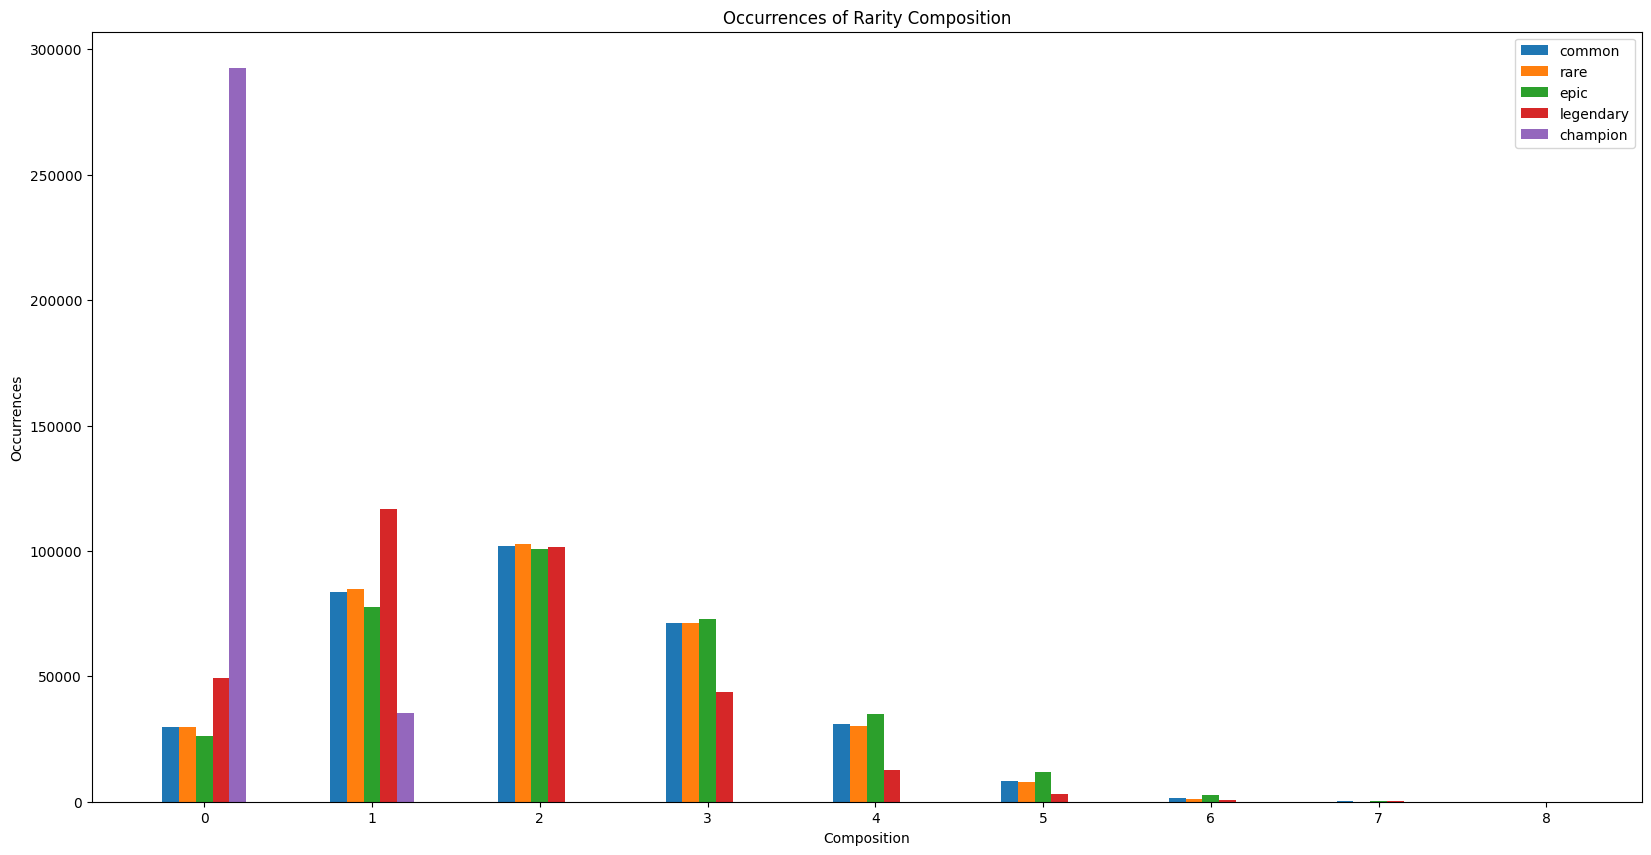

In [180]:
common = data_decks['Rarity'].apply(lambda x: int(x[4])).value_counts() # counting the number of commons
rare = data_decks['Rarity'].apply(lambda x: int(x[3])).value_counts() # counting the number of rares
epic = data_decks['Rarity'].apply(lambda x: int(x[2])).value_counts() # counting the number of epics
legendary = data_decks['Rarity'].apply(lambda x: int(x[1])).value_counts() # counting the number of legendaries
champion = data_decks['Rarity'].apply(lambda x: int(x[0])).value_counts() # counting the number of champions

# Creating plot
fig, ax = plt.subplots(figsize=(20,10))
# Setting labels
ax.set_ylabel("Occurrences")
ax.set_xlabel("Composition")
ax.set_title("Occurrences of Rarity Composition")
# Plotting occurrences of each composition
ax.bar(common.index-.2, common.values, .1, label='common')
ax.bar(rare.index-.1, rare.values, .1, label='rare')
ax.bar(epic.index, epic.values, .1, label='epic')
ax.bar(legendary.index+.1, legendary.values, .1, label='legendary')
ax.bar(champion.index+.2, champion.values, .1, label='champion')

ax.set_xticks(np.arange(9), ['0','1','2','3','4','5','6','7','8'])
plt.legend(loc="upper right")
plt.show()

#### Analyzing Deck average Elixir  

In [181]:
# creating a copy dataframe to manipluate for this section of the project 
elixir_analysis = data_decks.copy(deep=True)
elixir_analysis['losses'] = elixir_analysis['Occurrences'] -elixir_analysis['Wins']

# re-ordering loss column 
elixir_analysis = elixir_analysis[['Deck','Occurrences','Wins','losses','Rarity','Composition','Costs','Trophies','Win Rate']]

# re-naming loss costs column to Average Elixir Cost 
elixir_analysis.rename(columns={'Costs':'Average Elixir Cost'},inplace = True)
elixir_analysis

,Deck,Occurrences,Wins,losses,Rarity,Composition,Average Elixir Cost,Trophies,Win Rate
0,"(8, 34, 37, 52, 69, 88, 92, 97)",30,17,13,12212,035,4.250,6963.566667,0.566667
1,"(11, 12, 13, 58, 77, 86, 87, 98)",22,9,13,01331,224,3.250,7339.909091,0.409091
2,"(11, 37, 53, 83, 88, 92, 97, 102)",183,83,100,02213,143,3.750,6996.245902,0.453552
3,"(19, 22, 25, 32, 54, 76, 87, 98)",1778,959,819,02213,125,3.500,6912.115861,0.539370
4,"(28, 38, 43, 46, 50, 81, 102, 103)",1910,1064,846,02141,116,4.000,6769.385864,0.557068
...,...,...,...,...,...,...,...,...,...
327653,"(7, 15, 17, 21, 43, 81, 87, 89)",1,1,0,00341,125,4.500,5577.000000,1.000000
327654,"(13, 35, 39, 43, 48, 73, 95, 99)",1,1,0,02213,026,3.875,6087.000000,1.000000
327655,"(11, 17, 18, 24, 51, 77, 95, 102)",1,1,0,01142,125,4.125,5838.000000,1.000000
327656,"(4, 7, 11, 21, 64, 77, 88, 92)",1,0,1,00332,125,4.375,5858.000000,0.000000


##### Deck average elixir cost distribution 

In this section, we will look at the distribution of the deck average elixir cost for all the decks in our data.

We will also examine the min, max, median, and mean. 

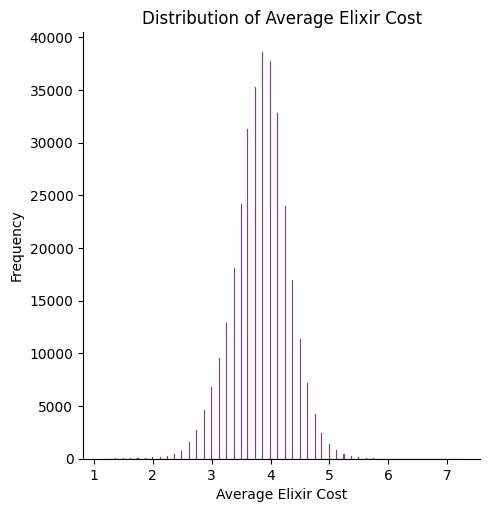

Min: 1.125 | Max: 7.25 | Median: 3.841473426560621 | Mean: 3.841473426560621


In [182]:
# using seaborn distribution plot function to plot Average Elixir Cost
sns.displot(elixir_analysis, x ='Average Elixir Cost', color = 'purple')
plt.xlabel("Average Elixir Cost")
plt.ylabel("Frequency")
plt.title("Distribution of Average Elixir Cost")
plt.show()

# Calculating the min, max, median, and mean for Average deck Elixir Cost
print("Min: "+str(elixir_analysis['Average Elixir Cost'].min())+" | "+ "Max: "+str(elixir_analysis['Average Elixir Cost'].max())+" | "+
    "Median: " +str(elixir_analysis['Average Elixir Cost'].mean())+" | "+ "Mean: "+str(elixir_analysis['Average Elixir Cost'].mean()))

From this distribution plot, we can see that the deck average elixir costs have a normal distribution with a peak of ~38,000 decks with an average elixir cost of ~3.8.

The resulting summary statistics were as follows: min = 1.125, max = 7.25, median = 3.875, and mean = 3.841. 

This correlates well with the distribution plot. 

This means that in the game, the majority of decks have around 3.8 average elixir cost.

##### Deck average deck elixir cost versus win rate scatterplot


In this section, we will look at the relationship between average deck elixir cost and win rate through a scatterplot.

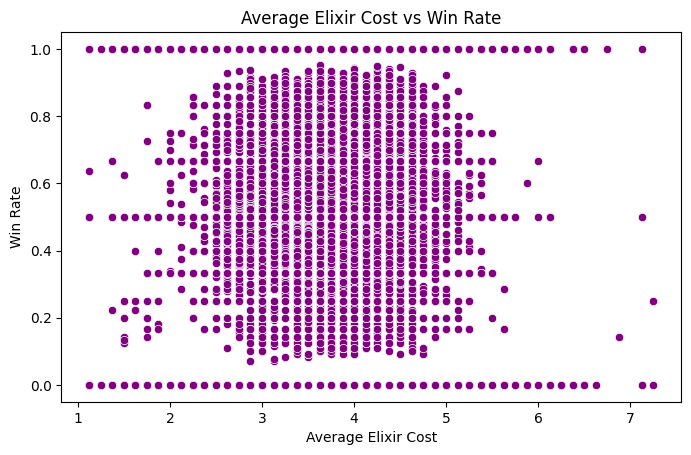

In [183]:
# using seaborn sns to plot scatterplot of Average Elixir Cost vs Win Rate
plt.figure().set_figwidth(8)
sns.scatterplot(data = elixir_analysis, x ='Average Elixir Cost', y = 'Win Rate', color = 'purple')
plt.title("Average Elixir Cost vs Win Rate")
plt.show()

From this scatterplot, we have found there is no visible relationship between average deck elixir cost and win rate.

We have also found that the decks between a 10% and 90% win rate have an elixir cost of between ~2.75 and ~4.75. 

##### Deck average trophies distribution 

In this section, we will look at the distribution of the deck average trophies for all the decks in our data. 

We will also examine the min, max, median, and mean.

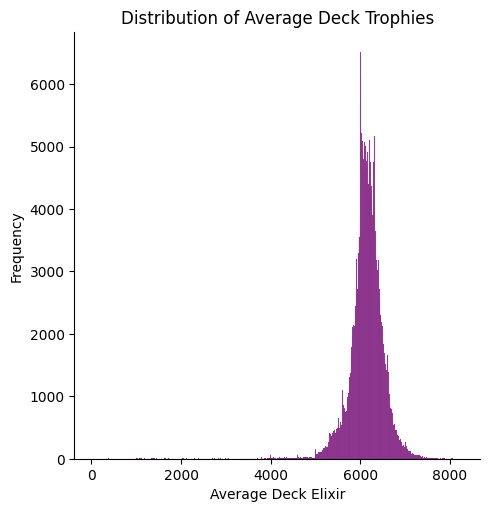

Min: 30.0 | Max: 8264.0 | Median: 6140.412407816404 | Mean: 6140.412407816404


In [184]:
# using seaborn distribution plot function to plot Average deck Trophies
sns.displot(elixir_analysis, x ='Trophies', color = 'purple')
plt.xlabel("Average Deck Elixir")
plt.ylabel("Frequency")
plt.title("Distribution of Average Deck Trophies")
plt.show()

# Calculating the min, max, median, and mean for Average deck Trophies
print("Min: "+str(elixir_analysis['Trophies'].min())+" | "+ "Max: "+str(elixir_analysis['Trophies'].max())+" | "+
    "Median: " +str(elixir_analysis['Trophies'].mean())+" | "+ "Mean: "+str(elixir_analysis['Trophies'].mean()))

From this distribution plot we can see that the average deck trophies have a normal distribution with a peak of ~6100 decks with average trophies of ~6000. 

The resulting summary statistics were as follows: min = 30.0, max = 8264.0, median = 6151.0, and mean = 6140.412.

 This correlates well with the distribution plot.

##### Deck average elixir cost versus deck average trophies scatterplot 

In this section, we will look at the relationship between deck average elixir cost and deck average trophies through a scatterplot.

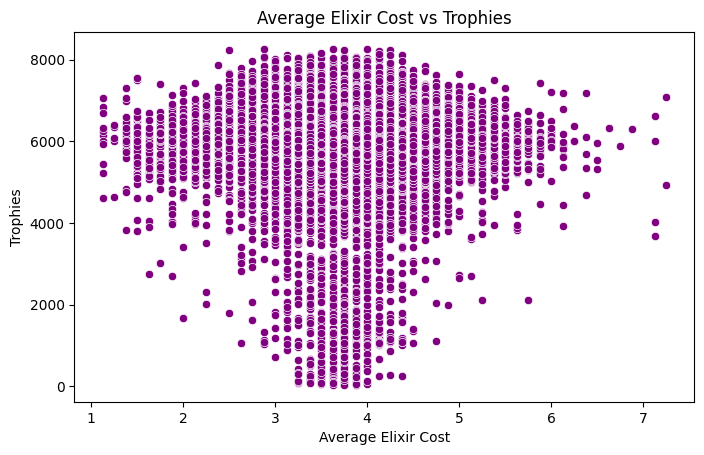

In [185]:
# using seaborn sns to plot scatterplot of Average Elixir Cost vs Trophies
plt.figure().set_figwidth(8)
sns.scatterplot(data = elixir_analysis, x ='Average Elixir Cost', y = 'Trophies', color = 'purple')
plt.title("Average Elixir Cost vs Trophies")
plt.show()

From this scatterplot, we have found there is no visible relationship between the deck average elixir cost and deck average trophies. 

We have also found that the decks between 4000 and 8000 average trophies have an elixir cost of between ~1.5 and ~5.5. 

#### Deck average elixir cost vs deck average trophies binned violin plot

In the following sections, we will look at the relationship between deck average elixir cost and deck average trophies through a violin plot binned by trophy ranges. 

The trophy ranges are in 6 bins as follows: 5000-5500, 6000-6500, 6500-7000, 7000-7500, 7500-8000, and 8000-8500. 

In [186]:
# creating bin ranges to id all trophies in the dataframe 
bins = [5000,5500,6000,6500,7000,7500,8500]
label = ['5000-5500','6000-6500','6500-7000','7000-7500','7500-8000','8000-8500']

# creating a new column which corresponds the trophies and bin for every deck
elixir_analysis['bins'] = pd.cut(elixir_analysis['Trophies'],bins=bins,labels=label)
elixir_analysis

,Deck,Occurrences,Wins,losses,Rarity,Composition,Average Elixir Cost,Trophies,Win Rate,bins
0,"(8, 34, 37, 52, 69, 88, 92, 97)",30,17,13,12212,035,4.250,6963.566667,0.566667,7000-7500
1,"(11, 12, 13, 58, 77, 86, 87, 98)",22,9,13,01331,224,3.250,7339.909091,0.409091,7500-8000
2,"(11, 37, 53, 83, 88, 92, 97, 102)",183,83,100,02213,143,3.750,6996.245902,0.453552,7000-7500
3,"(19, 22, 25, 32, 54, 76, 87, 98)",1778,959,819,02213,125,3.500,6912.115861,0.539370,7000-7500
4,"(28, 38, 43, 46, 50, 81, 102, 103)",1910,1064,846,02141,116,4.000,6769.385864,0.557068,7000-7500
...,...,...,...,...,...,...,...,...,...,...
327653,"(7, 15, 17, 21, 43, 81, 87, 89)",1,1,0,00341,125,4.500,5577.000000,1.000000,6000-6500
327654,"(13, 35, 39, 43, 48, 73, 95, 99)",1,1,0,02213,026,3.875,6087.000000,1.000000,6500-7000
327655,"(11, 17, 18, 24, 51, 77, 95, 102)",1,1,0,01142,125,4.125,5838.000000,1.000000,6000-6500
327656,"(4, 7, 11, 21, 64, 77, 88, 92)",1,0,1,00332,125,4.375,5858.000000,0.000000,6000-6500


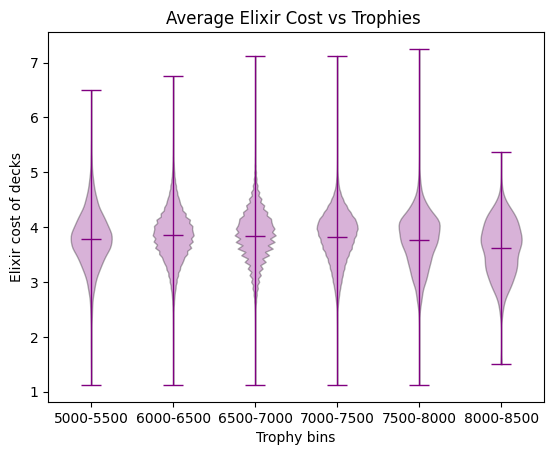

In [187]:
# Bins for trophies
bined = [1,2,3,4,5,6]
avg_elixir = []

# grouping binned trophies and getting the corresponding Average Elixir Cost
elixir_analysis.groupby("bins").apply(lambda x: avg_elixir.append(x["Average Elixir Cost"]))

# Constructing the plot using matplotlib violin plot function 
fig, ax = plt.subplots()

# showing means of each violin plot as well as changing the colors to purple
violin_plot = ax.violinplot(avg_elixir,bined,showmeans=True)
for vs in violin_plot['bodies']:
    vs.set_facecolor('purple')
    vs.set_edgecolor('black')
for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = violin_plot[partname]
    vp.set_edgecolor('purple')
    vp.set_linewidth(1)

# setting labels and title
ax.set_xlabel("Trophy bins")
ax.set_ylabel("Elixir cost of decks")

ax.set_xticks(bined)
ax.set_xticklabels(['5000-5500','6000-6500','6500-7000','7000-7500','7500-8000','8000-8500'])


plt.title("Average Elixir Cost vs Trophies ")
plt.show()

From the violin plot we can see that all decks within any of the bins generally have the same mean average elixir cost of around 3.9. 

We can also see that the decks with average trophies in the 8000-8500 range have more of a range of decks that are actually used and less of a range of outliers. 

This illustrates that there is a weak correlation between win rate and deck elixir cost with a high certainty.   

#### General Composition Conclusions

These results agree with the trend we found in the most and least common rarity compositions. There tends to be a majority of decks that are diverse. This also agrees with our findings that champions are not typically used. The usage data for common, rare, epic, and legendary cards is normally distributed, while the usage data of champions is not. 

## Hypothesis Testing
### Testing For Correlation Between Composition and Win Rate
We will be using two main tests to investigate correlation. We will use the Pearson Correlation Coefficient test whenever our data is normally distributed and the Spearman Correlation Coefficient test whenever our data is not normally distributed.
#### Null Hypothesis 1: There is no correlation between the number of units in a deck and win rate
Our Null Hypothesis states that correlation between the number of units in a deck and win rate is 0.
To attempt to accept or reject this, we will use a Pearson Correlation Coefficient test since the usage of units is normally distributed.

In [188]:
# There is no correlation between number of units and win rate
win_rate = data_decks['Win Rate']
units = data_decks['Composition'].apply(lambda x: int(x[2]))

corr, p = pearsonr(win_rate, units)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation P Value: %e' % p)

Pearsons correlation: -0.006
Pearsons correlation P Value: 7.056334e-04


This indicates that there is a weak negative correlation between the number of units in a deck and win rate. There is high certainty that the Null Hypothesis has been rejected since P Value < .01.

#### Null Hypothesis 2: There is no correlation between the number of spells in a deck and win rate
Our Null Hypothesis states that correlation between the number of spells in a deck and win rate is 0.
To attempt to accept or reject this, we will use a Pearson Correlation Coefficient test since the usage of spells is normally distributed.

In [189]:
# There is no correlation between number of spells and win rate
spells = data_decks['Composition'].apply(lambda x: int(x[1]))

corr, p = pearsonr(win_rate, spells)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %e' % p)

Pearsons correlation: 0.008
Pearsons correlation pval: 2.226059e-06


This indicates that there is a weak positive correlation between the number of spells in a deck and win rate. It is somewhat more significant than the correlation between units and win rate. There is high certainty that the Null Hypothesis has been rejected since P Value < .01.

#### Null Hypothesis 3: There is no correlation between the number of buildings in a deck and win rate
Our Null Hypothesis states that correlation between the number of buildings in a deck and win rate is 0.
To attempt to accept or reject this, we will use a Spearman Correlation Coefficient test since the usage of buildings is not normally distributed.

In [190]:
# There is no correlation between number of buildings and win rate
buildings = data_decks['Composition'].apply(lambda x: int(x[0]))

corr, p = spearmanr(win_rate, buildings)
print('Spearman correlation: %.3f' % corr)
print('Spearman correlation pval: %e' % p)

Spearman correlation: -0.002
Spearman correlation pval: 3.181563e-01


There is a weak negative correlation between buildings and win rate, but very high uncertainty about the result since P Value > .1. This means that we accept the Null Hypothesis that there is no correlation between buildings and win rate. One reason this P Value might have been so high is due to the lower usage of buildings in general.

### Testing For Correlation Between Rarity Composition and Win Rate
We will again be using the Pearson Correlation Coefficient test whenever our data is normally distributed and the Spearman Correlation Coefficient test whenever our data is not normally distributed.
#### Null Hypothesis 1: There is no correlation between the number of commons in a deck and win rate
Our Null Hypothesis states that correlation between the number of commons in a deck and win rate is 0.
To attempt to accept or reject this, we will use a Pearson Correlation Coefficient test since the usage of commons is normally distributed.

In [191]:
# There is no correlation between number of commons and win rate
common = data_decks['Rarity'].apply(lambda x: int(x[4]))

corr, p = pearsonr(win_rate, common)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %e' % p)

Pearsons correlation: -0.020
Pearsons correlation pval: 4.986060e-29


This indicates that there is a weak negative correlation between the number of commons in a deck and win rate. It is much more significant than the correlations found when analyzing composition. There is extremely high certainty that the Null Hypothesis has been rejected since P Value < .01.

#### Null Hypothesis 2: There is no correlation between the number of rares in a deck and win rate
Our Null Hypothesis states that correlation between the number of rares in a deck and win rate is 0.
To attempt to accept or reject this, we will use a Pearson Correlation Coefficient test since the usage of rares is normally distributed.

In [192]:
rare = data_decks['Rarity'].apply(lambda x: int(x[3]))

corr, p = pearsonr(win_rate, rare)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %e' % p)

Pearsons correlation: -0.024
Pearsons correlation pval: 3.793463e-42


This indicates that there is a weak negative correlation between the number of rares in a deck and win rate. It is more significant than the correlations between commons and win rate. There is extremely high certainty that the Null Hypothesis has been rejected since P Value < .01.

#### Null Hypothesis 3: There is no correlation between the number of epics in a deck and win rate
Our Null Hypothesis states that correlation between the number of epics in a deck and win rate is 0.
To attempt to accept or reject this, we will use a Pearson Correlation Coefficient test since the usage of epics is normally distributed.

In [193]:
epic = data_decks['Rarity'].apply(lambda x: int(x[2]))

corr, p = pearsonr(win_rate, epic)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %e' % p)

Pearsons correlation: 0.018
Pearsons correlation pval: 1.555940e-25


This indicates that there is a weak positive correlation between the number of epics in a deck and win rate. It is the first positive correlation found in rarity composition which may indicate higher rarities lead to better win rates. There is extremely high certainty that the Null Hypothesis has been rejected since P Value < .01.

#### Null Hypothesis 4: There is no correlation between the number of legendaries in a deck and win rate
Our Null Hypothesis states that correlation between the number of legendaries in a deck and win rate is 0.
To attempt to accept or reject this, we will use a Pearson Correlation Coefficient test since the usage of legendaries is normally distributed.

In [194]:
legendary = data_decks['Rarity'].apply(lambda x: int(x[1]))

corr, p = pearsonr(win_rate, legendary)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %e' % p)

Pearsons correlation: 0.023
Pearsons correlation pval: 1.151631e-38


This indicates that there is a weak positive correlation between the number of legendaries in a deck and win rate. It is also a positive correlation reaffirming the notion that higher rarity might lead to better win rate. It also is slightly stronger than the correlation between epics and win rate. There is extremely high certainty that the Null Hypothesis has been rejected since P Value < .01.

#### Null Hypothesis 5: There is no correlation between the number of champions in a deck and win rate
Our Null Hypothesis states that correlation between the number of champions in a deck and win rate is 0.
To attempt to accept or reject this, we will use a Spearman Correlation Coefficient test since the usage of champions is not normally distributed.

In [195]:
champion = data_decks['Rarity'].apply(lambda x: int(x[0]))

corr, p = spearmanr(win_rate, champion)
print('Spearman correlation: %.3f' % corr)
print('Spearman correlation pval: %e' % p)

Spearman correlation: 0.016
Spearman correlation pval: 1.146415e-20


There is a weak positive correlation between champions and win rate. This is also a positive correlation which cements the notion that higher rarities lead to higher win rate. There is extremely high certainty that the Null Hypothesis has been rejected since P Value < .01.
#### Analysis of Composition Results
We rejected all but one of the null hypotheses. From our results, we can assume that epics, legendaries, and champions all have higher correlations between win rate than commons and rares. Someone using these cards in high concentrations will most likely see slight win rate increases. That said, this is for high concentrations. Using diverse decks seems to be the most common and results in the highest win rates. 

Also, all of the correlations were generally pretty weak. This implies that ceratin compositions and rarities will not just win the game for you. This goes against many player's notions that higher rarity cards make the game "pay to win." What seems to be most important is having a diverse deck and individual player skill.

### Testing the correlation between Average Deck Elixir Cost and Win Rate

In this section, we will test the relationship between Average Elixir Cost and Win Rate by using a Pearson correlation coefficient test. 

#### Null Hypothesis 1: There is no correlation between the average deck elixir cost and win rate

In [196]:
win_rate_eli = elixir_analysis['Win Rate']
units_eli = elixir_analysis['Average Elixir Cost']

# calculating Pearsons correlation and Pearsons correlation p-value
corr, p = pearsonr(win_rate_eli, units_eli)

print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %e' % p)

Pearsons correlation: 0.011
Pearsons correlation pval: 1.022831e-09


We reject the null hypothesis as there is a weak positive correlation between average deck elixir cost and win rate. 

## Communication of Insights Attained

### Finding the most optimal deck

#### Visualizing deck win rate trends 

In this section we want to see the general trend in win rates as the number of times a deck is used increases. 

We also want to see if our data contains significant outliers that would skew our most optimal deck findings.

In [197]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

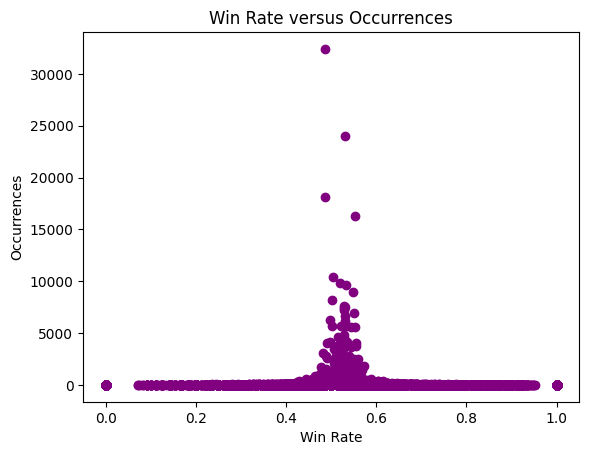

In [198]:
# Creating plot
fig, ax = plt.subplots()

# Setting labels
ax.set_ylabel("Occurrences")
ax.set_xlabel("Win Rate")
ax.set_title("Win Rate versus Occurrences")

# Plotting win rate by occurrences
ax.scatter(data_decks["Win Rate"],data_decks["Occurrences"],color="purple")
plt.show()

From this plot, we can see that there are outliers. The majority of decks were used very few times, however, as the number of occurrences increases we see the win rate trend to ~50%. This means that we should ignore decks that have very high win rate or very low win rate but low occurrences. 



#### Determining Statistically Important Decks 

In this section we will determine which decks are statistically significant decks through the use of Agresti Coull confidence intervals. Agresti Coull intervals are a means to find out how statistically significant something is based on the number of possible successes in a population. The factors that will lead to higher significance are a higher population size and high number of successes relative to population size. Decks used once are not as relevant when compared to decks used many times, and decks that lose a lot also will have low relevance. [This function](https://stackoverflow.com/questions/3749125/how-should-i-order-these-helpful-scores) returns the lower bound of significance with a 95% confidence interval.

We will find the 5 decks with the highest Relative Importance and the 5 decks with the lowest Relative Importance to ensure that the code works correctly. 

In [199]:
# This function finds the confidence that a score is relevant to our calculations
# This is important since decks used once are not as relevant when compared to decks used many times
# n = number of times this deck was used, k = number of wins for the deck
# Return value -> lower bound of range (how useful the information is basically)

def AgrestiCoullLower(n, k):
    # 95% confidence interval
    kappa = 2.24140273 #kappa = ierfc(conf/2)*sqrt(2)
    kest = k+kappa*kappa/2
    nest =n+kappa*kappa;
    pest=kest/nest;
    radius=kappa*math.sqrt(pest*(1-pest)/nest);
    return max(0,pest-radius); #Lower bound
    #Upper bound is min(1,pest+radius)

# adding 'Relative Importance' column 
data_decks['Relative Importance'] = data_decks.apply(lambda x: AgrestiCoullLower(x['Occurrences'],x['Wins']),axis = 1)

# sorting 'Relative Importance'
data_decks.sort_values(by = 'Relative Importance',ascending=False)


,Deck,Occurrences,Wins,Trophies,Rarity,Composition,Costs,Win Rate,Relative Importance
319296,"(4, 36, 45, 56, 57, 84, 88, 96)",40,38,5995.000000,00332,125,4.250,0.95,0.799481
66213,"(4, 5, 6, 12, 17, 35, 70, 92)",21,21,6898.380952,01412,017,4.375,1.00,0.773724
7157,"(6, 10, 11, 56, 77, 80, 88, 98)",18,18,5807.000000,01124,224,3.375,1.00,0.745265
123345,"(7, 27, 34, 37, 52, 92, 97, 99)",17,17,7032.294118,02510,035,4.250,1.00,0.734123
310704,"(9, 12, 13, 48, 49, 67, 70, 99)",16,16,7240.000000,11303,017,3.750,1.00,0.721964
...,...,...,...,...,...,...,...,...,...
196310,"(7, 11, 17, 18, 21, 49, 88, 101)",1,0,5940.000000,00152,026,3.750,0.00,0.000000
70169,"(11, 36, 45, 52, 55, 64, 95, 99)",1,0,6308.000000,01232,026,4.000,0.00,0.000000
196314,"(7, 12, 17, 18, 32, 49, 55, 98)",2,0,5936.000000,03221,017,3.875,0.00,0.000000
70166,"(12, 14, 24, 40, 49, 55, 88, 91)",1,0,6086.000000,01223,026,3.875,0.00,0.000000


The 5 decks with the highest Relative Importance were going on massive win streaks. For example, the highest Relative Importance belongs to a deck that won 38/40 games. This is very meaningful for determining the most optimal deck, as clearly this deck is doing something right. Meanwhile the decks with the lowest Relative Importance won 0/1 or 0/2 games. These decks are given a Relative Importance of 0.

#### Visualizing Relative Importance by Win Rate

In this section we will visualize the correlation between Relative Importance and Win Rate. We expect a positive correlation between Relative Importance and Win Rate to be found by the code above.

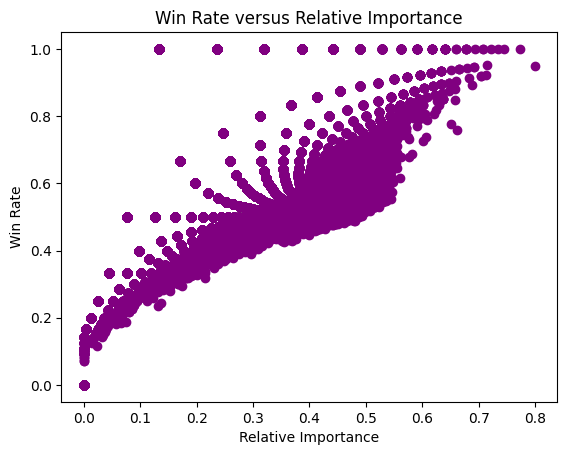

In [200]:
fig, ax = plt.subplots()

# Setting labels
ax.set_xlabel("Relative Importance")
ax.set_ylabel("Win Rate")
ax.set_title("Win Rate versus Relative Importance")

# Plotting Relative Importance by Win Rate
ax.scatter(data_decks["Relative Importance"], data_decks["Win Rate"], color = "purple")
plt.show()

This accurately depicts what we anticipiated. There is indeed a strong positive correlation between Relative Importance and Win Rate. We also noticed that there are many outlier decks that have a 100% Win Rate, but low Relative Importance. This means our code is accurately handling these cases and will allow us to proceed with finding the most optimal deck.

#### Ignoring Unimportant Decks

For our purposes, we will be ignoring decks with a Relative Importance below 50% and less than 35 occurrences. These decks have been played significantly which should give us the most accurate optimal deck.
##### Finding the most optimal composition
We will find the composition with the highest win rate and relative importance.

In [201]:
# Ignoring decks with under 40% relative importance and less than 100 occurrences
win_rates = data_decks[data_decks["Relative Importance"] >= .5][data_decks["Occurrences"] >= 35].groupby('Composition')['Win Rate'].mean() + data_decks[data_decks["Relative Importance"] >= .4].groupby('Composition')['Relative Importance'].mean()
print("Buildings: "+list(win_rates.index)[list(win_rates).index(win_rates.max())][0]+ ", Spells: "+list(win_rates.index)[list(win_rates).index(win_rates.max())][1]+ ", Units: "+list(win_rates.index)[list(win_rates).index(win_rates.max())][2])

Buildings: 2, Spells: 0, Units: 6


##### Finding the most optimal rarity composition
We will find the rarity composition with the highest win rate and relative importance.

In [202]:
# Ignoring decks with under 40% relative importance and less than 100 occurrences
win_rates = data_decks[data_decks["Relative Importance"] >= .5][data_decks["Occurrences"] >= 35].groupby('Rarity')['Win Rate'].mean() + data_decks[data_decks["Relative Importance"] >= .4].groupby('Rarity')['Relative Importance'].mean()
print("Champions: "+list(win_rates.index)[list(win_rates).index(win_rates.max())][0]+ ", Legendaries: "+list(win_rates.index)[list(win_rates).index(win_rates.max())][1]+ ", Epics: "+list(win_rates.index)[list(win_rates).index(win_rates.max())][2]+ ", Rare: "+list(win_rates.index)[list(win_rates).index(win_rates.max())][3]+ ", Common: "+list(win_rates.index)[list(win_rates).index(win_rates.max())][4])

Champions: 0, Legendaries: 0, Epics: 3, Rare: 3, Common: 2


##### Finding the most optimal deck average elixir cost
We will find the deck average elixir cost with the highest win rate and relative importance.

In [203]:
# Ignoring decks with under 40% relative importance and less than 100 occurrences
win_rates = data_decks[data_decks["Relative Importance"] >= .5][data_decks["Occurrences"] >= 35].groupby('Costs')['Win Rate'].mean() + data_decks[data_decks["Relative Importance"] >= .4].groupby('Costs')['Relative Importance'].mean()
print("Average Elixir Cost: "+str(list(win_rates.index)[list(win_rates).index(win_rates.max())]))

Average Elixir Cost: 4.5


#### Finding the Most Optimal Deck

Now we will build a deck with the following criteria:
- 2 buildings and 6 units
- 3 epics, 3 rares, and 2 commons
- roughly 4.5 average deck elixir cost

In [204]:
builds = ['building','siege','defense','spawner']

buildings = card_df[card_df['type'].isin(builds)].sort_values(by='winrate',ascending=False).head(2)

unit_epic = card_df[card_df['type'] == 'unit'][card_df['rarity'] == 'epic'].sort_values(by='winrate',ascending=False).head(3)

unit_rare = (card_df[card_df['type'] == 'unit'][card_df['rarity'] == 'rare'].sort_values(by='winrate',ascending=False).head(2))

unit_common = (card_df[card_df['type'] == 'unit'][card_df['rarity'] == 'common'].sort_values(by='winrate',ascending=False).head(1))


con = [buildings,unit_epic,unit_rare,unit_common]
optimus = pd.concat(con)
display(optimus)
print("The average elixir cost for our most optimal deck is: "+str(optimus['cost'].mean()))


,card,wins,occurrences,winrate,card_name,cost,rarity,type
42,85,61153,117324,0.521232,Goblin Cage,4.0,rare,building
18,83,39439,75832,0.520084,Tombstone,3.0,common,spawner
54,54,32352,61037,0.530039,Cannon Cart,5.0,epic,unit
1,34,35229,66651,0.528559,Bowler,5.0,epic,unit
35,60,16932,32185,0.526084,Goblin Giant,6.0,epic,unit
3,52,23700,45047,0.526117,Zappies,4.0,rare,unit
93,57,41858,80031,0.523022,Flying Machine,4.0,rare,unit
98,70,22406,42334,0.529267,Skeleton Dragons,4.0,common,unit


The average elixir cost for our most optimal deck is: 4.375


This is the deck we found based on the criteria above: 
- Goblin Cage
- Tombstone
- Cannon Cart 
- Bowler 
- Goblin Giant 
- Zappies 
- Flying Machines 
- Skeleton Dragons 

### Conclusion

The deck that we found consists of: 


<img src="LOL.PNG" alt="Alternative text" width ="600" height = "500"/>


- Goblin Cage 
- Tombstone
- Cannon Cart 
- Bowler 
- Goblin Giant 
- Zappies 
- Flying Machines 
- Skeleton Dragons 

Many parts of this deck are consistent with our findings. All the cards in our deck had a win rate above 50%, despite seeing significant play. A win rate above 50% indicates that our deck would help a player increase their rank. Three of the eight cards in our deck are amongst the top 5 highest win rate cards. These were Cannon Cart, Bowler, and Skeleton Dragons. Additionally, our deck consisted of six units which was the most frequent number of units in a composition. In terms of rarity composition, our deck was somewhat standard. The most frequent number of occurrences for commons, rares and epics was 2. In our deck, there are 2 commons, 3 rares, and 3 epics. 

There were many surprising aspects of this deck. Our optimal deck had no spells and two buildings. We found that most decks utilized no buildings whatsoever whereas a high number of decks had an average of two spells. We found that the building type has a weak negative correlation with win rate meaning that the more buildings in a deck, the worse that deck is found to be. In contrast,  the spell type had a weak positive correlation with win rate. Despite this, it did not show up at all. However, this does not mean that the deck is bad. The correlations were so weak that we agreed player skill was the determining factor in what makes a good deck. Decks do not need to be built a certain way to compete.

From our findings, we believe the game is not “pay-to-win” because there are no champion rarity cards in our most optimal deck, and there are no legendary rarity cards in our most optimal deck. Our deck consisted of cards with “epic” or lower rarity which are easily obtainable by the average player. In the future, we may continue this analysis by looking at data that also includes each card’s level. The matches we sampled are from high ranks, meaning most of these players would have similar cards with similar levels. In lower ranks, this is not always the case and one could argue level advantage is more important than deck composition. Examining whether this claim is true would be a good way to further disprove that this game is “pay-to-win.”